In [1]:
import pandas as pd
import numpy as np
import os
import time
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import polars as pl
import json
import pickle

import lightgbm as lgb
import catboost as cbt
import xgboost as xgb

from itertools import combinations
from contextlib import contextmanager
from enum import Enum
from typing import List, Tuple
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
pd.set_option("display.max_columns", 200, "display.max_rows", 100)

In [2]:
%load_ext autoreload
%autoreload 2

from utils import *

In [3]:
DATA_DIR = Path("../optiver")
OUT_DIR = Path("../optiver/working")
MODEL_DIR = Path("../optiver/models")

ID_COLS = ["date_id", "stock_id", "seconds_in_bucket"]
SPLIT_DAY = 400
CUTOFF_DATE = 480
WINDOW = 60
NUM_BOOST_ROUND = 300
EARLY_STOPPING_ROUNDS = 100
RANDOM_STATE = 123

X_MIN, X_MAX = -9000000000, 9000000000
NAN_VAL = -90000000000
USE_PRECOMPUTE_FEATURES = True
STORE_FEATURES = False
OFFLINE = False
TRAIN_LGBM = True
CV = True
CV_MODE = "random"

#### Load Data

In [4]:
with timer("load training data"):
    data = pd.read_parquet(os.path.join(DATA_DIR, "train.pq")).sort_values(by=ID_COLS)
with timer("reduce memory for training data"):
    data = reduce_mem_usage(data, verbose=True)
    data = data[~data["target"].isna()]

if USE_PRECOMPUTE_FEATURES:
    X_train = pd.read_parquet(os.path.join(OUT_DIR, "features_train_full.pq"))
else:
    with timer("make features"):
        X_train, _ = create_features(data)
    with open(os.path.join(OUT_DIR, f"selected_features_169.json")) as f:
        selected_features = json.load(f)["selected_features_names"]
    with timer("impute missing values"):
        X_train = impute_missing_values(X_train, selected_features)
    with timer("reduce memory for features"):
        X_train = reduce_mem_usage(X_train, verbose=True)
        print("training data:", X_train.shape)

[load training data]  3.159sec
Mem. usage decreased to 274.74 Mb (61.8% reduction)
reduce memory use: 0.4
[reduce memory for training data]  1.194sec


#### Refit Model Using Latest Data

In [5]:
with open(os.path.join(OUT_DIR, f"selected_features_169.json")) as f:
    selected_features = json.load(f)["selected_features_names"]

if OFFLINE:
    X_train = X_train.loc[X_train["date_id"] >= SPLIT_DAY].reset_index(drop=True).replace({np.inf: X_MAX, -np.inf: X_MIN})
    y_train = data.loc[data["date_id"] >= SPLIT_DAY, ID_COLS + ["target"]].reset_index(drop=True)
    with timer("create cross-validation folds"):
        folds = make_cv_folds(X_train, n_folds=5, mode=CV_MODE)
    with timer("train xgb on selected features"):
        fitted_models = train_xgb(X_train, y_train["target"], folds, selected_features, n_trials=100)
else:
    fitted_models = []
    for i in range(5):
        model = xgb.XGBRegressor()
        model.load_model(os.path.join(MODEL_DIR, f"xgb_feat_169_80d_fold{i}.model"))
        fitted_models.append(model)
    X_train = X_train.loc[X_train["date_id"] >= CUTOFF_DATE - WINDOW, ["date_id"] + selected_features].reset_index(drop=True).replace({np.inf: X_MAX, -np.inf: X_MIN})
    y_train = data.loc[data["date_id"] >= CUTOFF_DATE - WINDOW, ID_COLS + ["target"]].reset_index(drop=True)

#### In-Sample Hit Rate

In [ ]:
X_train["y_pred"] = list(make_ensemble(X_train[selected_features].replace({np.inf: X_MAX, -np.inf: X_MIN}), fitted_models))
X_train["y_true"] = data["target"].values

X_train["date_id"] = X_train["date_id"].astype(np.int16)
X_train["seconds_in_bucket"] = X_train["seconds_in_bucket"].astype(np.int16)
X_train["stock_id"] = X_train["stock_id"].astype(np.int16)

weighted_means = X_train.groupby(["date_id", "seconds_in_bucket"]).apply(lambda g: (g["y_pred"] * g["stock_weight"]).sum() / g["stock_weight"].sum()).rename("weighted_mean")
X_train = X_train.merge(weighted_means, left_on=["date_id", "seconds_in_bucket"], right_index=True)
X_train[f"y_pred_post_process"] = X_train["y_pred"] - X_train["weighted_mean"]

In [48]:
hit_rate_cs1 = X_train.groupby(["date_id"]).apply(lambda gp: np.nanmean((np.sign(gp["y_pred"]) * np.sign(gp["y_true"]) + 1) / 2))
hit_rate_cs2 = X_train.groupby(["seconds_in_bucket"]).apply(lambda gp: np.nanmean((np.sign(gp["y_pred"]) * np.sign(gp["y_true"]) + 1) / 2))
hit_rate_ts = X_train.groupby(["stock_id"]).apply(lambda gp: np.nanmean((np.sign(gp["y_pred"]) * np.sign(gp["y_true"]) + 1) / 2))

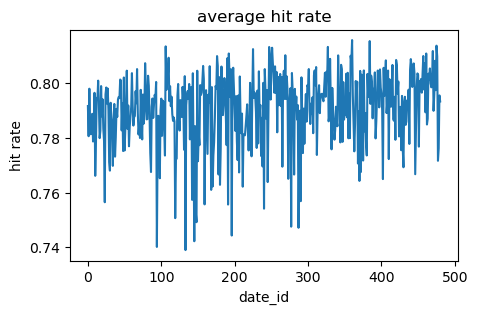

In [45]:
plt.figure(figsize=(5, 3))
plt.plot(hit_rate_cs1)
plt.title("average hit rate")
plt.xlabel("date_id")
plt.ylabel("hit rate")
plt.show()

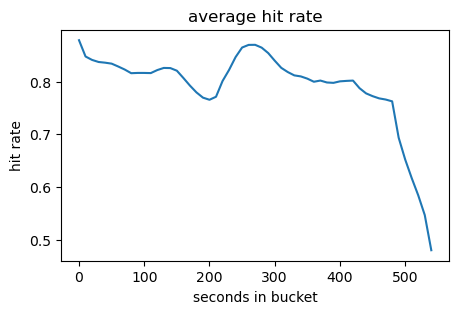

In [46]:
plt.figure(figsize=(5, 3))
plt.plot(hit_rate_cs2)
plt.title("average hit rate")
plt.xlabel("seconds in bucket")
plt.ylabel("hit rate")
plt.show()

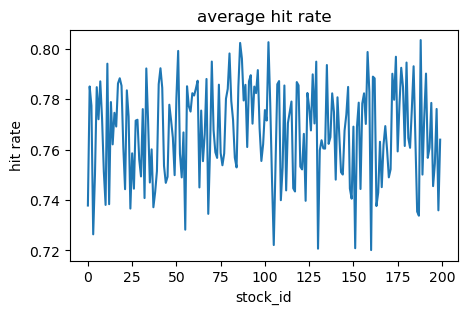

In [51]:
plt.figure(figsize=(5, 3))
plt.plot(hit_rate_ts)
plt.title("average hit rate")
plt.xlabel("stock_id")
plt.ylabel("hit rate")
plt.show()

#### Submission

In [ ]:
import optiver2023

env = optiver2023.make_env()
iter_test = env.iter_test()

res = []

best_params = {
    "lambda": 9.717295575427032,
    "alpha": 7.86752872768018,
    "eta": 0.6,
    "gamma": 24,
    "learning_rate": 0.02,
    "colsample_bytree": 0.6,
    "colsample_bynode": 0.9,
    "n_estimators": 153,
    "min_child_weight": 8,
    "max_depth": 7,
    "subsample": 0.5,
}

for counter, (test, revealed_targets, sample_prediction) in enumerate(iter_test):
    curr_second = int(test.seconds_in_bucket.unique()[0])
    curr_date = int(test.date_id.max())
    currently_scored = test.currently_scored.unique()[0]

    with timer(f"counter {counter}: date {curr_date}, second {curr_second}, scored {currently_scored}"):
        try:
            test, revealed_targets = clean_format(test, revealed_targets, curr_date_id=curr_date)
            if (curr_second == 0) and (curr_date > CUTOFF_DATE):
                if y_train.shape[0] < X_train.shape[0]:
                    y_train = pd.concat([y_train, revealed_targets], ignore_index=True, axis=0)

            if curr_date > CUTOFF_DATE:
                X_test, _ = create_features_with_revealed_targets(test, y_train, curr_date, curr_second)
                X_test = impute_missing_values(X_test, selected_features)
                X_test = X_test[["date_id"] + selected_features].replace({np.inf: X_MAX, -np.inf: X_MIN})  # 170 columns
                X_train = pd.concat([X_train, reduce_mem_usage(X_test, verbose=False)], ignore_index=True, axis=0)  # 170 columns
            else:
                X_test = X_train.loc[(X_train["date_id"] == curr_date) & (X_train["seconds_in_bucket"] == curr_second)]  # 170 columns

            # update models - online training
            if (curr_date % 20 == 0) and (curr_date >= 560) and (curr_second == 540):
                X_train = X_train[X_train["date_id"] >= curr_date - WINDOW].reset_index(drop=True)  # 170 columns
                y_train = y_train[y_train["date_id"] >= curr_date - WINDOW].reset_index(drop=True)
                with timer(f"refit model using data from date {curr_date-WINDOW} - date {curr_date}"):
                    fitted_models = [refit_xgb(best_params, X_train, y_train["target"], selected_features, seed=(RANDOM_STATE + i * 10)) for i in range(5)]
        except:
            sample_prediction["target"] = 0
            env.predict(sample_prediction)
            continue

        # make predictions
        X_test = X_test.assign(y_pred=list(make_ensemble(X_test[selected_features], fitted_models)))
        y_pred_wap = (X_test["y_pred"] * X_test["stock_weight"]).sum() / X_test["stock_weight"].sum()  # post-processing
        if X_test.shape[0] != sample_prediction.shape[0]:
            X_test["row_id"] = test["row_id"]
            X_test = X_test.set_index(["row_id"]).reindex(pd.Index(sample_prediction["row_id"]))
        assert X_test.shape[0] == sample_prediction.shape[0]
        sample_prediction["target"] = np.nan_to_num((X_test["y_pred"] - y_pred_wap).to_numpy(dtype=np.float64), nan=0, posinf=Y_MAX, neginf=Y_MIN)
        env.predict(sample_prediction)
        res.append(sample_prediction)